In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import tushare as ts
from tqdm import tqdm

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [13]:
'''
pro = ts.pro_api()
data = pro.index_daily(ts_code='000905.SH') 
data.to_excel('000905.xlsx',index=False)
'''
data = pd.read_excel('000905.xlsx')

In [7]:
data

,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,000905.SH,20221226,5843.2555,5769.0686,5850.9115,5769.0686,5763.3458,79.9097,1.3865,75424133.00,9.364610e+07
1,000905.SH,20221223,5763.3458,5751.9489,5805.5101,5732.4711,5779.0555,-15.7097,-0.2718,66556865.00,8.191119e+07
2,000905.SH,20221222,5779.0555,5867.7240,5875.4736,5761.9836,5845.8350,-66.7795,-1.1423,82231873.00,9.744680e+07
3,000905.SH,20221221,5845.8350,5879.2722,5892.9070,5819.6676,5878.0314,-32.1964,-0.5477,69783431.00,8.525778e+07
4,000905.SH,20221220,5878.0314,5919.0267,5920.9868,5857.8575,5936.4751,-58.4437,-0.9845,78623273.00,9.636967e+07
...,...,...,...,...,...,...,...,...,...,...,...
4365,000905.SH,20050110,1006.3370,996.9280,1006.4570,993.1230,997.6060,8.7310,0.8752,2949405.33,1.650219e+06
4366,000905.SH,20050107,997.6060,993.4340,1009.0000,990.4460,994.5950,3.0110,0.3027,3391626.98,1.906531e+06
4367,000905.SH,20050106,994.5950,1003.4900,1003.4900,990.7920,1003.6330,-9.0380,-0.9005,2933905.59,1.629216e+06
4368,000905.SH,20050105,1003.6330,986.5700,1008.8550,985.6770,986.9270,16.7060,1.6927,3486101.13,1.919862e+06


In [8]:
data.sort_values('trade_date',inplace=True)
data.pct_chg = data.pct_chg*0.01

In [9]:
data.reset_index(inplace=True,drop=True)
data.set_index('trade_date',inplace=True)
data.index = pd.DatetimeIndex(data.index)

In [10]:
def cal_moment(arr,n=5):
    '''
    arr:数据序列
    n:阶数
    '''
    arr = np.array(arr)
    return np.mean(arr**n)

In [11]:
def ema(arr,alpha):
    series = pd.Series(arr)
    return series.ewm(alpha=alpha,adjust=False).mean().iloc[-1]
 

In [54]:
for i in range(1,10):
    data.loc[:,str(i)+'阶矩']=data.pct_chg.rolling(window=20).apply(cal_moment,args=(i,))     #apply传参  写在args里

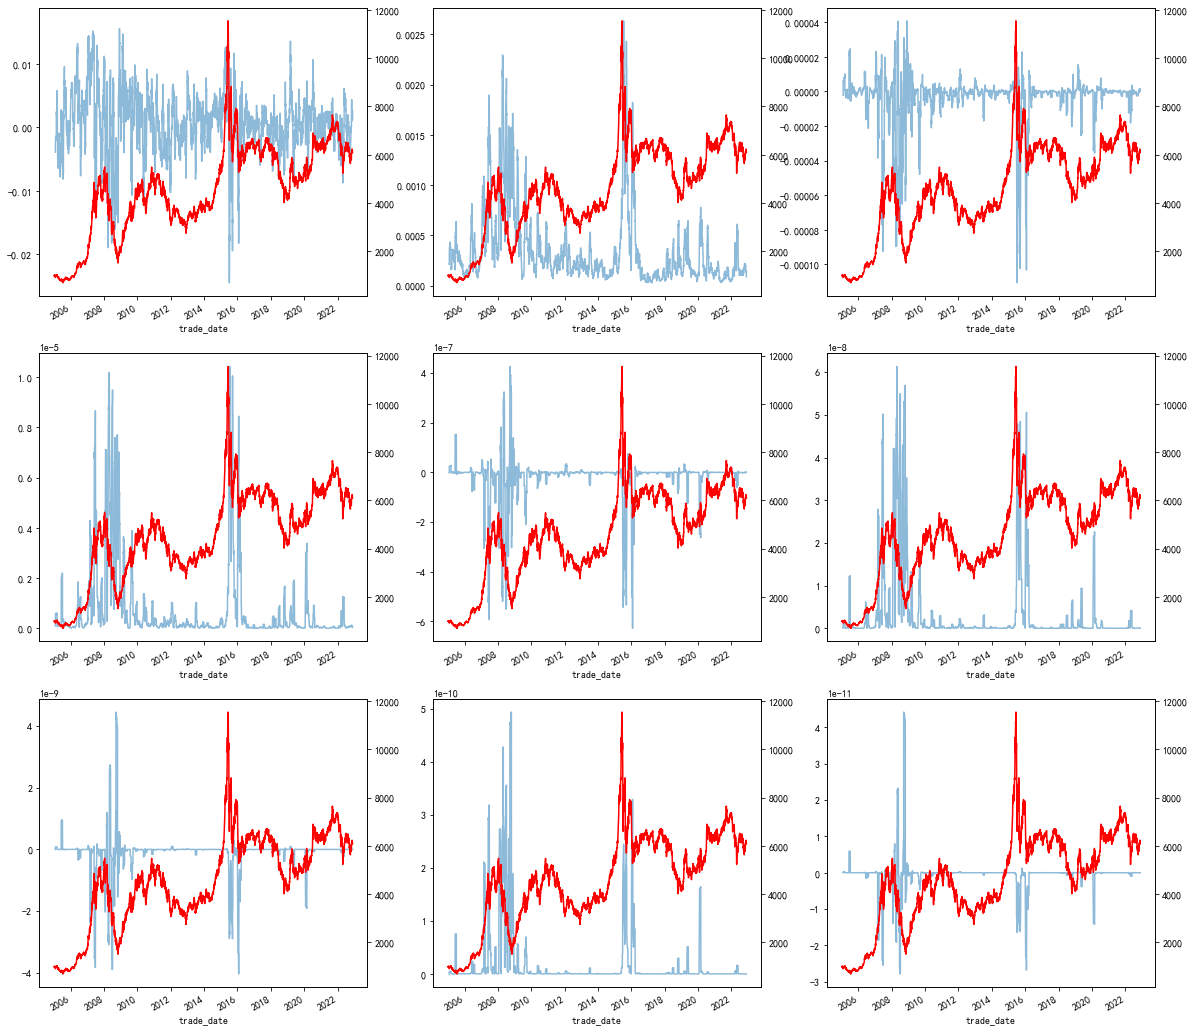

In [55]:
plt.figure(figsize=(20,20))
for i in range(1,10):
    ax1 = plt.subplot(3,3,i)
    data[str(i)+'阶矩'].plot(ax=ax1,alpha=0.5)
    ax2 = ax1.twinx() 
    data['close'].plot(color='red',ax=ax2)
plt.savefig('高阶矩.svg')

In [10]:
def evaluate_investment(source_data, tittle, daily_return, freq='daily', time='日期'):
    '''
    source_data:  策略净值曲线, DataFrame
    title:  source_data的净值曲线列名称, str
    daily_return:  source_data的每日回报列名称, str
    freq:  source_data的数据频率,默认日频,频率影响夏普比率的算法,str
    time:  source_data的日期列名称, str
    '''
    temp = source_data.copy()
    
    # ===新建一个dataframe保存回测指标
    results = pd.DataFrame()

    # ===计算累积净值
    results.loc[0, '累积净值'] = round(temp[tittle].iloc[-1], 2)

    # ===计算年化收益
    annual_return = (temp[tittle].iloc[-1]) ** (
            '1 days 00:00:00' / (temp[time].iloc[-1] - temp[time].iloc[0]) * 365) - 1
    results.loc[0, '年化收益'] = str(round(annual_return * 100, 2)) + '%'

    # ===计算最大回撤
    # 计算当日之前的资金曲线的最高点
    temp['max2here'] = temp[tittle].expanding().max()
    # 计算到历史最高值到当日的跌幅，drowdwon
    temp['dd2here'] = temp[tittle] / temp['max2here'] - 1
    # 计算最大回撤，以及最大回撤结束时间
    end_date, max_draw_down = tuple(temp.sort_values(by=['dd2here']).iloc[0][[time, 'dd2here']])
    # 计算最大回撤开始时间
    start_date = temp[temp[time] <= end_date].sort_values(by=tittle, ascending=False).iloc[0][
        time]
    
    # ===计算年化夏普比率
    # 设定无风险利率为当前隔夜Shibor, 策略净值为日频，周（252改50），月（252改12）
    riskfree_rate = 0.0131
    
    if freq =='daily':
        p_count = 252
    elif freq =='weekly':
        p_count = 50
    elif freq == 'monthly':
        p_count = 12
    else:
        print('源数据频率输入有误，请更正。')
    annual_std =  temp[daily_return].std() * (p_count ** 0.5)
    results.loc[0, '夏普比率'] =  round((annual_return - riskfree_rate) / annual_std ,2)
   
    # 将无关的变量删除
    temp.drop(['max2here', 'dd2here'], axis=1, inplace=True)
    results.loc[0, '最大回撤'] = format(max_draw_down, '.2%')
    results.loc[0, '最大回撤开始时间'] = str(start_date)
    results.loc[0, '最大回撤结束时间'] = str(end_date)

    # ===年化收益/回撤比
    results.loc[0, '年化收益/回撤比'] = round(annual_return / abs(max_draw_down), 2)

    return results.T

16.177457545788556


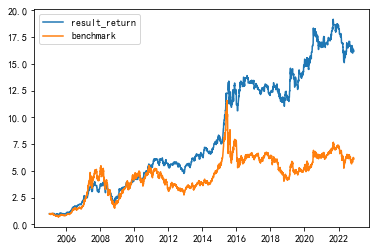

In [77]:
def get_position(ret,cond,loss=0.1):
    '''
    ret:收益率
    cond:信号序列
    '''
    df = pd.concat([ret,cond],axis=1) 
    df.columns = ['ret','cond']
    position = []      
    loss_flag = 1
    df.reset_index(inplace=True)
    for i in range(len(df)-1):
        if position:
            # 开仓信号，大于止损线
            if df.loc[i,'cond'] and loss_flag >=1-loss:
                position.append(1)
                loss_flag = loss_flag*(1+df.loc[i+1,'ret'])
                loss_flag = min(1,loss_flag)
            else:      
                position.append(0) 
                loss_flag = 1         
        else:           
            if df.loc[i,'cond'] and loss_flag >=1-loss:
                position.append(1)
                loss_flag = loss_flag*(1+df.loc[i+1,'ret'])
                loss_flag = min(1,loss_flag)
            else:
                position.append(0)
                loss_flag = 1
    position.append(np.NAN)
    df['position'] = position
    
    df.set_index('trade_date',inplace=True)
    return df

ema_window = 40#原文给出窗口期
alpha = 0.05
result_series = data['5阶矩'].rolling(ema_window).apply(ema,args=(0.55,)) 
cond_series = result_series>result_series.shift(1)
ret = data.loc[:,'pct_chg']

result_return = get_position(ret, cond_series,loss=0.1)
result_return = result_return['ret'].shift(-1) * result_return['position']
cum = (1 + result_return).cumprod()
benchmark = (1 + ret).cumprod()
plt.plot(pd.DataFrame({'result_return':cum,'benchmark':benchmark}))
plt.legend(['result_return','benchmark'])
print(cum.dropna()[-1])
plt.savefig('单向看多择时.svg')


In [13]:
results =  pd.DataFrame({'result_return':cum,'benchmark':benchmark})
results.reset_index(inplace=True)
results.loc[:,'每日回报'] = results.result_return.pct_change()
r1 = pd.DataFrame(evaluate_investment(results.dropna(), 'result_return', '每日回报', freq='daily', time='trade_date'))

In [30]:
def get_biposition(ret,cond,loss=0.1):
    '''
    ret:收益率
    cond:信号序列
    '''
    df = pd.concat([ret,cond],axis=1) 
    df.columns = ['ret','cond']
    position = []      
    loss_flag = 1
    df.reset_index(inplace=True)
    for i in range(len(df)-1):
        if position:
            # 开仓信号，大于止损线
            if position[-1] == 1:
                if df.loc[i,'cond'] and loss_flag >=1-loss:
                    position.append(1)
                    loss_flag = loss_flag*(1+df.loc[i+1,'ret'])
                    loss_flag = min(1,loss_flag)
                else:      
                    position.append(-1) 
                    loss_flag = 1  
            elif position[-1] == -1:
                if df.loc[i,'cond']==False and loss_flag >=1-loss:
                    position.append(-1)
                    loss_flag = loss_flag*(1-df.loc[i+1,'ret'])
                    loss_flag = min(1,loss_flag)
                else:      
                    position.append(1) 
                    loss_flag = 1  

        else:           
            if df.loc[i,'cond'] and loss_flag >=1-loss:
                position.append(1)
                loss_flag = loss_flag*(1+df.loc[i+1,'ret'])
                loss_flag = min(1,loss_flag)
            else:
                position.append(-1)
                loss_flag = loss_flag*(1-df.loc[i+1,'ret'])
                loss_flag = min(1,loss_flag)
    position.append(np.NAN)
    df['position'] = position
    df.set_index('trade_date',inplace=True)
    return df

In [15]:
pd.notna(np.NAN)

False

4.811229014666166


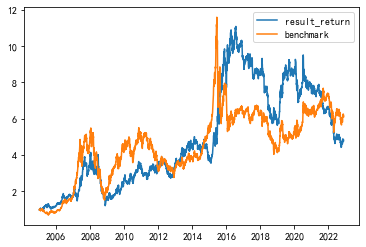

In [61]:
'''
双向多空
'''
ema_window = 120#原文给出窗口期
alpha = 0.05
result_series = data['5阶矩'].rolling(ema_window).apply(ema,args=(0.05,)) 
cond_series = result_series>result_series.shift(1)
ret = data.loc[:,'pct_chg']
result_return = get_biposition(ret, cond_series,loss=0.1)
result_return = result_return['ret'].shift(-1) * result_return['position']
cum = (1 + result_return).cumprod()
benchmark = (1 + ret).cumprod()
plt.plot(pd.DataFrame({'result_return':cum,'benchmark':benchmark}))
plt.legend(['result_return','benchmark'])
print(cum.dropna()[-1])
plt.savefig('双向多空择时.svg')


In [17]:
results =  pd.DataFrame({'result_return':cum,'benchmark':benchmark})
results.reset_index(inplace=True)
results.loc[:,'每日回报'] = results.result_return.pct_change()
r2 = pd.DataFrame(evaluate_investment(results.dropna(), 'result_return', '每日回报', freq='daily', time='trade_date'))

In [18]:
r1.columns=['单向看多择时']
r2.columns=['双向多空择时']
print(pd.merge(r1,r2,left_index=True,right_index=True).to_markdown())

|                  | 单向看多择时        | 双向多空择时        |
|:-----------------|:--------------------|:--------------------|
| 累积净值         | 9.52                | 14.68               |
| 年化收益         | 13.42%              | 16.2%               |
| 夏普比率         | 0.69                | 0.56                |
| 最大回撤         | -59.43%             | -68.50%             |
| 最大回撤开始时间 | 2008-01-11 00:00:00 | 2008-06-30 00:00:00 |
| 最大回撤结束时间 | 2009-01-22 00:00:00 | 2009-07-31 00:00:00 |
| 年化收益/回撤比  | 0.23                | 0.24                |


In [90]:
r1.index

Index(['累积净值', '年化收益', '夏普比率', '最大回撤', '最大回撤开始时间', '最大回撤结束时间', '年化收益/回撤比'], dtype='object')

In [78]:
result_series = pd.DataFrame()
'''
    动态寻优调整alpha
'''
from tqdm import tqdm

windows = 90
ema_window = 40
for i in tqdm(range(1,len(data)//windows )):
    if i <len(data)//windows  -2 :
        tem = []
        for alpha in np.arange(0.05,0.7,0.05):
            tem_1 = data.iloc[:(i+1)*windows,14].rolling(ema_window).apply(ema,args=(alpha,))
            tem_1 = tem_1.iloc[-windows:,]
            ret = data.loc[tem_1.index].pct_chg 
            tem_2 = tem_1>tem_1.shift(1)
            result_return = get_position(ret, tem_2)
            result_return = result_return['ret'].shift(-1) * result_return['position']
            cum = (1 + result_return).cumprod().dropna()
            tem.append(cum[-1])

        alpha = (np.argmax(tem)+1)*0.05
        tem_3 = data.iloc[:(i+2)*windows,14].rolling(ema_window).apply(ema,args=(alpha,))
        tem_3 = tem_3.iloc[-windows:]
        tem_4 = tem_3>tem_3.shift(1)        
        result_series = pd.concat([result_series,tem_4])

100%|██████████| 47/47 [02:56<00:00,  3.75s/it]


11.982734446822823


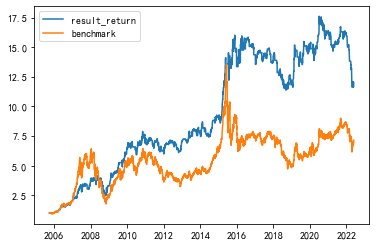

In [79]:
result_series.loc[:,'trade_date'] = result_series.index
result_series.set_index('trade_date',inplace=True)
result_series=result_series.loc[result_series.index.drop_duplicates()]
ret = data.loc[result_series.index].pct_chg 
result_return = get_position(ret, result_series[0])
result_return = result_return['ret'].shift(-1) * result_return['position']
cum = (1 + result_return).cumprod()
benchmark = (1 + ret).cumprod()
plt.plot(pd.DataFrame({'result_return':cum,'benchmark':benchmark}))
plt.legend(['result_return','benchmark'])
print(cum.dropna()[-1])
plt.savefig('单向看多择时(alpha动态).svg')

In [177]:
results =  pd.DataFrame({'result_return':cum,'benchmark':benchmark})
results.reset_index(inplace=True)
results.loc[:,'每日回报'] = results.result_return.pct_change()
r1 = pd.DataFrame(evaluate_investment(results.dropna(), 'result_return', '每日回报', freq='daily', time='trade_date'))

In [178]:
r1

,0
累积净值,9.9
年化收益,14.73%
夏普比率,0.77
最大回撤,-50.94%
最大回撤开始时间,2008-01-11 00:00:00
最大回撤结束时间,2008-11-10 00:00:00
年化收益/回撤比,0.29


In [19]:
result_series = pd.DataFrame()
'''
    动态寻优调整alpha
'''
from tqdm import tqdm

windows = 90
ema_window = 120
for i in tqdm(range(1,len(data)//windows )):
    if i <len(data)//windows  -2 :
        tem = []
        for alpha in np.arange(0.05,0.55,0.05):
            tem_1 = data.iloc[:(i+1)*windows,14].rolling(ema_window).apply(ema,args=(alpha,))
            tem_1 = tem_1.iloc[-windows:,]
            ret = data.loc[tem_1.index].pct_chg 
            tem_2 = tem_1>tem_1.shift(1)
            result_return = get_biposition(ret, tem_2)
            result_return = result_return['ret'].shift(-1) * result_return['position']
            cum = (1 + result_return).cumprod().dropna()
            tem.append(cum[-1])

        alpha = (np.argmax(tem)+1)*0.05
        tem_3 = data.iloc[:(i+2)*windows,14].rolling(ema_window).apply(ema,args=(alpha,))
        tem_3 = tem_3.iloc[-windows:]
        tem_4 = tem_3>tem_3.shift(1)        
        result_series = pd.concat([result_series,tem_4])

100%|██████████| 47/47 [02:05<00:00,  2.66s/it]


13.067492545326735


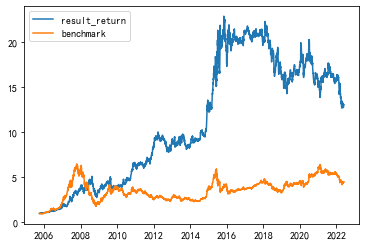

In [20]:
result_series.loc[:,'trade_date'] = result_series.index
result_series.set_index('trade_date',inplace=True)
result_series=result_series.loc[result_series.index.drop_duplicates()]
ret = data.loc[result_series.index].pct_chg 
result_return = get_biposition(ret, result_series[0])
result_return = result_return['ret'].shift(-1) * result_return['position']
cum = (1 + result_return).cumprod()
benchmark = (1 + ret).cumprod()
plt.plot(pd.DataFrame({'result_return':cum,'benchmark':benchmark}))
plt.legend(['result_return','benchmark'])
print(cum.dropna()[-1])
plt.savefig('双向多空择时(alpha动态).svg')

In [21]:
results =  pd.DataFrame({'result_return':cum,'benchmark':benchmark})
results.reset_index(inplace=True)
results.loc[:,'每日回报'] = results.result_return.pct_change()
r2 = pd.DataFrame(evaluate_investment(results.dropna(), 'result_return', '每日回报', freq='daily', time='trade_date'))

In [22]:
r2

,0
累积净值,13.07
年化收益,16.66%
夏普比率,0.58
最大回撤,-45.87%
最大回撤开始时间,2008-08-15 00:00:00
最大回撤结束时间,2008-11-18 00:00:00
年化收益/回撤比,0.36


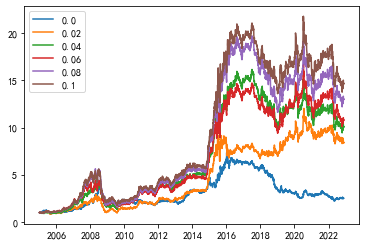

In [23]:
'''
  不同止损阈值
'''
ema_window = 120#原文给出窗口期
alpha = 0.05
result_series = data['5阶矩'].rolling(ema_window).apply(ema,args=(0.05,)) 
cond_series = result_series>result_series.shift(1)
ret = data.loc[:,'pct_chg']
tem = {}
for i in np.arange(0,0.11,0.02):
    result_return = get_biposition(ret, cond_series,loss=i)
    result_return = result_return['ret'].shift(-1) * result_return['position']
    cum = (1 + result_return).cumprod()
    benchmark = (1 + ret).cumprod()
    tem[i] = cum 
    plt.plot(pd.DataFrame({'result_return':cum}))
    plt.legend(list(np.arange(0,0.11,0.02)))

plt.savefig('不同止损阈值.svg')

In [24]:
def year_returns(series):
    return ((series.iloc[-1]/series.iloc[0])**(252/len(series))-1)*100

In [25]:
df = pd.DataFrame(tem).dropna()

In [26]:
df.groupby(pd.Grouper(freq='Y')).apply(year_returns)

,0.00,0.02,0.04,0.06,0.08,0.10
trade_date,,,,,,
2005-12-31,-4.739669,-9.017397,-6.538318,10.216949,8.218265,9.006333
2006-12-31,36.294806,60.170005,90.569831,92.509009,88.797028,89.125812
2007-12-31,74.377460,53.963855,94.807095,95.774744,148.387808,156.848811
2008-12-31,-3.349368,-51.232686,-48.793670,-52.128957,-59.234464,-55.497709
2009-12-31,3.403343,31.337737,25.524992,7.052002,10.638430,6.774537
2010-12-31,-2.009247,48.297239,60.831859,60.413063,57.500097,58.546655
2011-12-31,-4.515353,3.032000,16.361013,9.674836,16.752654,13.793686
2012-12-31,6.292412,15.885481,8.032023,11.327500,18.986199,18.986199
2013-12-31,44.331246,24.012233,15.739026,23.171961,20.063727,19.681939


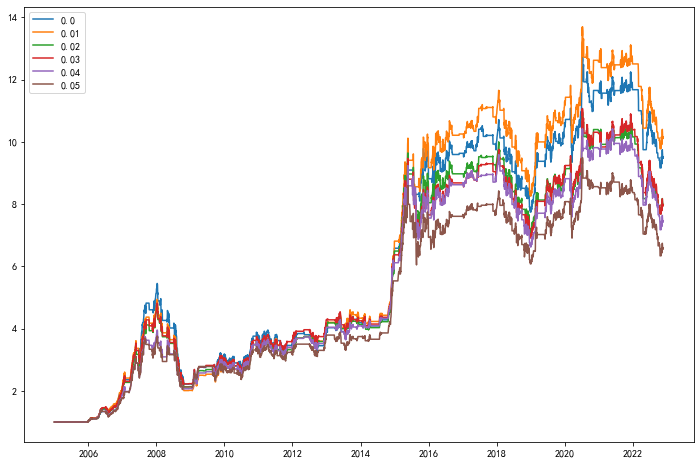

In [40]:
ema_window = 120#原文给出窗口期
alpha = 0.05
result_series = data['5阶矩'].rolling(ema_window).apply(ema,args=(0.05,))
'''
def func(x,k):
    if x >k:
        return True
    elif x<-k:
        return False
    else:
        return False
'''
plt.figure(figsize=(12,8))
for k in np.arange(0,0.06,0.01):
    result_series = pd.DataFrame(result_series)
    cond_series = result_series['5阶矩']>result_series['5阶矩'].shift(1)*(1+k)

    ret = data.loc[:,'pct_chg']
    tem = {}

    result_return = get_position(ret, cond_series,loss=0.1)
    result_return = result_return['ret'].shift(-1) * result_return['position']
    cum = (1 + result_return).cumprod()
    benchmark = (1 + ret).cumprod()
    tem[i] = cum 
    plt.plot(pd.DataFrame({'result_return':cum}))
    plt.legend(list(np.arange(0,0.06,0.01)))

plt.savefig('单向看多择时，不同阈值开仓.svg')

In [380]:
for k in np.arange(0,0.06,0.01):
    result_series = pd.DataFrame(result_series)
    cond_series = result_series['5阶矩']>result_series['5阶矩'].shift(1)*(1+k)

    ret = data.loc[:,'pct_chg']
    tem = {}

    result_return = get_biposition(ret, cond_series,loss=0.1)
    result_return = result_return['ret'].shift(-1) * result_return['position']
    cum = (1 + result_return).cumprod()
    benchmark = (1 + ret).cumprod()
    tem[i] = cum 
    plt.plot(pd.DataFrame({'result_return':cum}))
    plt.legend(list(np.arange(0,0.06,0.01)))


trade_date
2005-08-02         NaN
2005-08-03   -0.046951
2005-08-04   -0.045706
2005-08-05   -0.046227
2005-08-08   -0.046021
                ...   
2022-11-21    0.117201
2022-11-22    0.098332
2022-11-23    0.086263
2022-11-24    0.074993
2022-11-25    0.076877
Name: 5阶矩, Length: 4211, dtype: float64

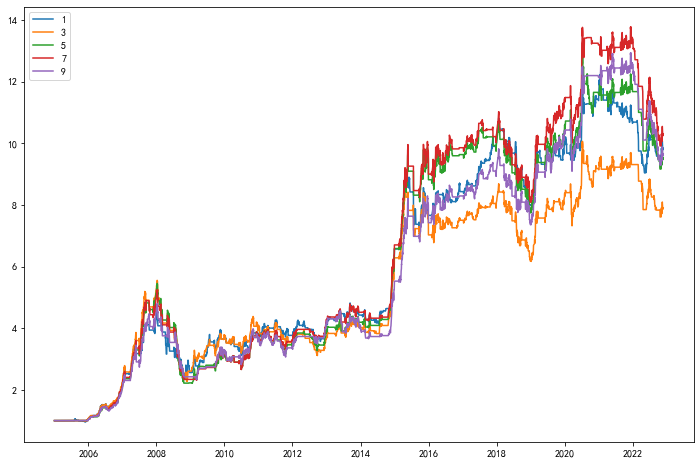

In [43]:
plt.figure(figsize=(12,8))
ema_window = 120#原文给出窗口期
alpha = 0.05

for k in np.arange(1,10,2):
    result_series = data[str(k)+'阶矩'].rolling(ema_window).apply(ema,args=(0.05,))
    result_series = pd.DataFrame(result_series)
    cond_series = result_series[str(k)+'阶矩']>result_series[str(k)+'阶矩'].shift(1)

    ret = data.loc[:,'pct_chg']
    tem = {}

    result_return = get_position(ret, cond_series,loss=0.1)
    result_return = result_return['ret'].shift(-1) * result_return['position']
    cum = (1 + result_return).cumprod()
    benchmark = (1 + ret).cumprod()
    tem[i] = cum 
    plt.plot(pd.DataFrame({'result_return':cum}))
    plt.legend(list(np.arange(1,10,2)))

plt.savefig('不同阶矩测试(单向).svg')